In [1]:
from d2l import tensorflow as d2l
import tensorflow as tf
%matplotlib inline

import sys
sys.path.append("/home/hpczeji1/hpc-work/Codebase/AllAbout_DeepLearning/Tutorial/my_tf_pipline/")
from backbone.rnn import RNNModel
from utils.dataset import generate_function_seq_dataset

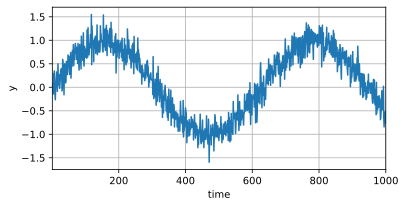

In [6]:
# 1&2 data and dataloader 
T, tau = 1000, 100  #! tau is the length of seq, too long cause too few samples, too short cause not enough info to predict
train_data, labels, y, time = generate_function_seq_dataset(T = T, tau=tau,if_plot=True)
batch_size, n_train = 16, 600  # 600 samples for traning, 400 for testing
train_iter = d2l.load_array((train_data[:n_train],labels[:n_train]), batch_size, is_train=True)

In [7]:
# 3 
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(10,activation="relu"),
#     tf.keras.layers.Dense(1)
# ])

from backbone.mlp import Sequential_Regression_MLP,get_Sequential_Regression_MLP
from backbone.rnn import get_Sequential_Regression_LSTM
model = get_Sequential_Regression_MLP() # Sequential_Regression_MLP()

# model = get_Sequential_Regression_LSTM(units = 64, output_size = 1)

In [31]:
in_out_neurons = 1
hidden_neurons = 256

model = tf.keras.Sequential()  
#! batch_input_shape is super important 
model.add(tf.keras.layers.LSTM(hidden_neurons, batch_input_shape=(None, tau, in_out_neurons), return_sequences=False))  
model.add(tf.keras.layers.Dense(in_out_neurons))  
model.add(tf.keras.layers.Activation("linear"))  
# model.compile(loss="mean_squared_error", optimizer="rmsprop")
# model.fit(train_data, labels, batch_size=600, epochs=15, validation_split=0.05)

In [14]:
# 3 model
"""num_hiddens = 256
run_cell = tf.keras.layers.SimpleRNNCell(num_hiddens, kernel_initializer = "glorot_uniform") # DEFAULT
rnn_layer = tf.keras.layers.RNN(
      run_cell,
      time_major=True,  # If True, the inputs and outputs will be in shape `(timesteps, batch, ...)`, otherwise reverse
      return_sequences=True,
      return_state=True)

# initialization
batch_size, num_steps = 32, 35
state = run_cell.get_initial_state(batch_size=batch_size, dtype = tf.float32)
state.shape # batach_size and num_hiddens
# X = tf.random.uniform((num_steps, batch_size, 1))
# Y, state_new = rnn_layer(X,state) # first forward
# Y.shape,len(state_new),state_new[0].shape

# model set 
# model = keras.Sequential() # model built in seequential way
# model.add(keras.layers.Embedding(input_dim=len(vocab), output_dim=256))
# model.add(keras.layers.Dense(10))
# model.summary()
model = RNNModel(rnn_layer,vocab_size = 1)
# 4&5
device_name = d2l.try_gpu()._device_name
stragegy = tf.distribute.OneDeviceStrategy(device_name)

with stragegy.scope():
    model = RNNModel(rnn_layer, 1)

# d2l.predict_ch8("time travellor", 10, model, vocab)  # with out training the results is weird
# model.compile(optimizer="Adam", loss = tf.keras.losses.mean_squared_logarithmic_error) # ,metrics=['accuracy'] # Kers have log version of MeanSquaredError 
# # reshaped_x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
# model.fit(train_iter, vocab, epochs=200,batch_size=32,verbose=0)
# model.summary()
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, 1, lr, num_epochs,stragegy) # 没有对应的vocab"""

In [32]:
# 4&5
loss = tf.keras.losses.MeanSquaredError()

from utils.trainer import d2l_train

d2l_train(model, train_iter,loss, epochs= 100, lr = 0.01)

epoch 1, loss: 0.046971
epoch 2, loss: 0.047331
epoch 3, loss: 0.049381
epoch 4, loss: 0.049325
epoch 5, loss: 0.049839
epoch 6, loss: 0.047639
epoch 7, loss: 0.045784
epoch 8, loss: 0.049649
epoch 9, loss: 0.047811
epoch 10, loss: 0.043587
epoch 11, loss: 0.044863
epoch 12, loss: 0.044989
epoch 13, loss: 0.047661
epoch 14, loss: 0.043629
epoch 15, loss: 0.043244
epoch 16, loss: 0.045190
epoch 17, loss: 0.045877
epoch 18, loss: 0.047819
epoch 19, loss: 0.043284
epoch 20, loss: 0.051088
epoch 21, loss: 0.048072
epoch 22, loss: 0.045908
epoch 23, loss: 0.044829
epoch 24, loss: 0.044313
epoch 25, loss: 0.045320
epoch 26, loss: 0.046390
epoch 27, loss: 0.045566
epoch 28, loss: 0.043565
epoch 29, loss: 0.046985
epoch 30, loss: 0.044852
epoch 31, loss: 0.044946
epoch 32, loss: 0.043868
epoch 33, loss: 0.043213
epoch 34, loss: 0.042527
epoch 35, loss: 0.043588
epoch 36, loss: 0.042936
epoch 37, loss: 0.043275
epoch 38, loss: 0.045795
epoch 39, loss: 0.043757
epoch 40, loss: 0.047262
epoch 41,

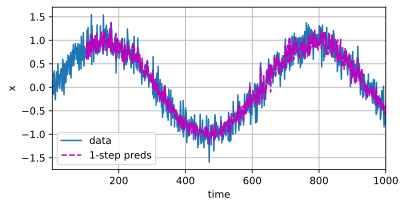

In [9]:
#1 one step  prediction
onestep_preds = model(train_data)
len(onestep_preds) # 996

d2l.plot([time, time[tau:]],
         [y.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

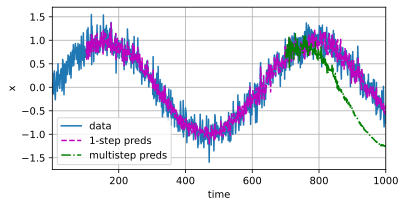

In [11]:
#2 Onestep but  Must use our own new predictions (not the raw data) to make multi-step predictions
multisteps_preds = tf.Variable(tf.zeros(T))
multisteps_preds[:n_train+tau].assign(y[:n_train+tau])
for i in range(n_train+tau, T):
    # print(multisteps_preds[i-tau:i].shape) # (4,) --> (1,4)
    multisteps_preds[i].assign(tf.reshape(model(
        tf.reshape(multisteps_preds[i-tau:i],(1,-1))), ())) #! predict based on former prediction cause cumulative error
        #  Model Input tensor must be at least 2D:so need reshape to (-1,1)
        # then reshape to scale again


d2l.plot([time, time[tau:], time[n_train + tau:]],
         [y.numpy(), onestep_preds.numpy(), multisteps_preds[n_train + tau:].numpy()], 
         'time', 'x', 
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

(837, 164) (837,)
(837, 100)
tf.Tensor(
[[ 0.7671722 ]
 [ 0.99022084]
 [ 0.7007615 ]
 [ 0.9114916 ]
 [ 0.7287835 ]
 [ 0.82956666]
 [ 0.8335749 ]
 [ 0.87368536]
 [ 0.6378148 ]
 [ 0.7246328 ]
 [ 0.819035  ]
 [ 0.87021893]
 [ 0.94268185]
 [ 0.99163634]
 [ 0.69123393]
 [ 0.775294  ]
 [ 0.6932476 ]
 [ 0.9608579 ]
 [ 1.1243035 ]
 [ 0.66405016]
 [ 0.90873736]
 [ 0.78153414]
 [ 0.78355473]
 [ 0.9500297 ]
 [ 0.87462795]
 [ 0.8291111 ]
 [ 0.8606876 ]
 [ 0.8233992 ]
 [ 0.9987865 ]
 [ 0.85468894]
 [ 0.9618998 ]
 [ 1.027289  ]
 [ 0.819629  ]
 [ 0.9341615 ]
 [ 1.0396487 ]
 [ 0.7977067 ]
 [ 0.68642807]
 [ 1.2179809 ]
 [ 0.76421845]
 [ 0.74432236]
 [ 1.1070932 ]
 [ 1.1077797 ]
 [ 0.86855894]
 [ 0.8851151 ]
 [ 1.0027381 ]
 [ 0.9860409 ]
 [ 1.056746  ]
 [ 0.924504  ]
 [ 0.7878687 ]
 [ 0.97143847]
 [ 0.9024585 ]
 [ 0.8639279 ]
 [ 0.8370328 ]
 [ 0.8910821 ]
 [ 0.8295419 ]
 [ 0.87472993]
 [ 1.1339612 ]
 [ 1.0024091 ]
 [ 1.0337588 ]
 [ 0.7205298 ]
 [ 1.3222973 ]
 [ 0.91752845]
 [ 0.93341607]
 [ 0.6579917 ]


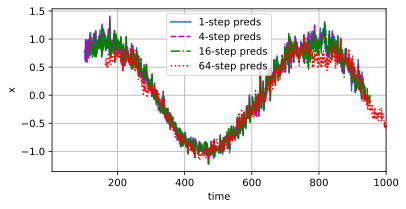

In [30]:
#3 multi steps prediction, loner future prediction

max_steps = 64

features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps))) # 一个二维数组，每一列从0到tau到tau+max_step，而0-tau列采用y默认值即可
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i].assign(y[i: i + T - tau - max_steps + 1].numpy())
print((T - tau - max_steps + 1, tau + max_steps),features[:,163].shape)  #!为了方便，每一步都是T - tau - max_steps + 1（如837的长度序列）

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):#!把tau 到tau+64的每n步预测都保留下来了（max——steps为最大步长，实际每个步长都走过）
    if i == 116:
        print(features[:, i - tau: i].shape)
        print(model((features[:, i - tau: i])))
    features[:, i].assign(tf.reshape(model((features[:, i - tau: i])), -1))  #! i-tau+1 control how many steps model predict once
    #! 为何上述可以预测k步，因为step越大，i-tau:i的长度就越大（也就是k=1,用此前tau个累计误差预测下一个,K=64则得用tau个累计误差预测64个）
    #! 不是这样k步是指：从当下时间，直接预测后第64个，还是预测一个值，只不过离得更远【这也是下图64步，直接从163才开始的原因】
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))